In [1]:
from copy import deepcopy
import numpy as np
import dijkstar

import trimesh
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
mesh_types = ['arch_box',
              'rect_box',
              'square_box',
              'half_cylinder_box',
              'triangle_box',
              'twin_tower_goal',
              'box_goal',
              'custom_table']
mesh_files = ['/home/kj/robosuite/robosuite/models/assets/objects/meshes/arch_box.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/rect_box.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/square_box.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/half_cylinder_box.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/triangle_box.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/twin_tower_goal.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/box_goal.stl',
              '/home/kj/robosuite/robosuite/models/assets/objects/meshes/custom_table.stl']
mesh_units = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01]
n_mesh_types = len(mesh_types)

meshes = []
for mesh_type, mesh_file, unit in zip(mesh_types, mesh_files, mesh_units):
    mesh = trimesh.load(mesh_file)

    # centering a mesh
    mesh.apply_scale(unit)
    mesh.apply_translation(-mesh.center_mass)
    mesh = mesh.subdivide()
#     mesh = mesh.subdivide()

    # set random stable pose
    if mesh_type is not "custom_table":
        stable_poses, probs = mesh.compute_stable_poses()
        stable_pose_idx = np.argmax(probs)

    meshes.append(mesh)

In [3]:
def visualize_mesh(_mesh, _mesh_pose, ax=None, color=None):
    if ax is None:
        plt.figure()
        ax = plt.gca(projection='3d')
    if color is None:
        color = [np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5]
        
    transformed_vertices = (_mesh_pose[:3, :3].dot(_mesh.vertices.T) + _mesh_pose[:3, [3]]).T
    transformed_vertex_normals = (_mesh_pose[:3, :3].dot(_mesh.vertex_normals.T) + _mesh_pose[:3, [3]]).T
    
    ax.plot_trisurf(transformed_vertices[:, 0], transformed_vertices[:, 1], transformed_vertices[:, 2],
                    triangles=_mesh.faces,
                    linewidth=0.2, antialiased=True, color=color, edgecolor=None)
    return ax

In [4]:
test_mesh = deepcopy(meshes[1])
test_mesh_pose = np.eye(4)
print(np.max(test_mesh.area_faces))

0.0012250000000000002


In [5]:
test_mesh2 = deepcopy(meshes[2])
test_mesh2_pose = np.eye(4)
print(np.max(test_mesh2.area_faces))

0.0006125000000000001


# Contact and Place Point Discretization

In [6]:
def create_rotation_mtx_from_z_x(z_axis):
    x_axis = [1, 0, 0]
    y_axis = np.cross(z_axis, x_axis)
    if np.sqrt(np.sum(y_axis ** 2)) > 0:
        y_axis = y_axis / np.sqrt(np.sum(y_axis ** 2))
    else:
        x_axis = [0, 1, 0]
        y_axis = np.cross(z_axis, x_axis)
        if np.sqrt(np.sum(y_axis ** 2)) > 0:
            y_axis = y_axis / np.sqrt(np.sum(y_axis ** 2))
        else:
            x_axis = [0, 0, 1]
            y_axis = np.cross(z_axis, x_axis)

    T = np.eye(4)
    T[:3, 0] = x_axis
    T[:3, 1] = y_axis
    T[:3, 2] = z_axis

    return T

In [7]:
# if test_mesh.faces.shape[0] > 64:
#     contact_face_indices = np.where(test_mesh.area_faces > np.max(test_mesh.area_faces)*0.8)
#     contact_points = np.mean(test_mesh.vertices[test_mesh.faces[contact_face_indices]], axis=1)
# else:
contact_face_indices = np.arange(test_mesh.faces.shape[0])
contact_points = np.mean(test_mesh.vertices[test_mesh.faces], axis=1)
    
# if test_mesh2.faces.shape[0] > 64:
#     contact_face_indices2 = np.where(test_mesh2.area_faces > np.max(test_mesh2.area_faces)*0.8)
#     contact_points2 = np.mean(test_mesh2.vertices[test_mesh2.faces[contact_face_indices]], axis=1)
# else:
contact_face_indices2 = np.arange(test_mesh2.faces.shape[0])
contact_points2 = np.mean(test_mesh2.vertices[test_mesh2.faces], axis=1)

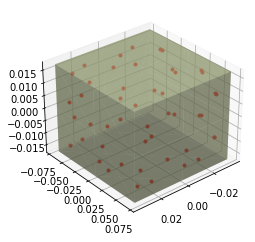

In [8]:
ax = plt.gca(projection='3d')
ax = visualize_mesh(test_mesh, test_mesh_pose, ax)
ax.plot(contact_points[:,0], contact_points[:,1], contact_points[:,2], '.r')
ax.view_init(30, 50)
plt.show()

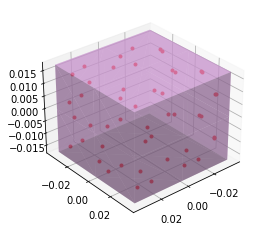

In [9]:
ax = plt.gca(projection='3d')
ax = visualize_mesh(test_mesh2, test_mesh2_pose, ax)
ax.plot(contact_points2[:,0], contact_points2[:,1], contact_points2[:,2], '.r')
ax.view_init(30, 50)
plt.show()

In [10]:
goal_mesh = deepcopy(meshes[5])
goal_mesh_pose = np.eye(4)

goal_contact_points = np.mean(goal_mesh.vertices[goal_mesh.faces], axis=1)

goal_contact_face_indices, = np.where(goal_contact_points[:,2]==np.min(goal_contact_points,axis=0)[2])
goal_contact_points = goal_contact_points[goal_contact_face_indices]

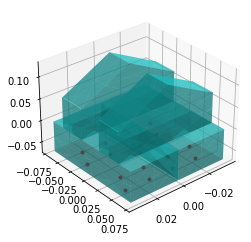

In [11]:
ax = plt.gca(projection='3d')
ax = visualize_mesh(goal_mesh, goal_mesh_pose, ax)
ax.plot(goal_contact_points[:,0], goal_contact_points[:,1], goal_contact_points[:,2], '.r')
ax.view_init(30, 50)
plt.show()

In [12]:
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac), 0],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab), 0],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc, 0],
                     [0, 0, 0, 1]])

In [13]:
pnt1 = contact_points[0]
normal1 = test_mesh.face_normals[contact_face_indices[0]]
print(normal1.shape)

pnts2 = goal_contact_points[0]
normal2 = goal_mesh.face_normals[goal_contact_face_indices[0]]
print(normal2.shape)

target_pnts = pnt1 + 1e-10 * normal1
target_normals = normal1
T_target = create_rotation_mtx_from_z_x(target_normals).dot(rotation_matrix([0, 0, 1], 
                                                                            np.pi/2.))
T_target[:3, 3] = target_pnts

T_source = create_rotation_mtx_from_z_x(normal2)
T_source[:3, 3] = pnts2

T2 = T_source.dot(np.linalg.inv(T_target))

(3,)
(3,)


In [60]:
pnt_idx = 12
pnt1 = contact_points2[pnt_idx]
normal1 = test_mesh2.face_normals[contact_face_indices2[pnt_idx]]
print(normal1.shape)

pnt_idx2 = 10
pnts2 = contact_points[pnt_idx2]
normal2 = test_mesh.face_normals[contact_face_indices[pnt_idx2]]
print(normal2.shape)

target_pnts = pnt1 + 1e-10 * normal1
target_normals = -normal1
T_target = create_rotation_mtx_from_z_x(target_normals).dot(rotation_matrix([0, 0, 1], 
                                                                            np.pi/2.))
T_target[:3, 3] = target_pnts

T_source = create_rotation_mtx_from_z_x(normal2)
T_source[:3, 3] = pnts2

T22 = T2.dot(T_source.dot(np.linalg.inv(T_target)))

(3,)
(3,)


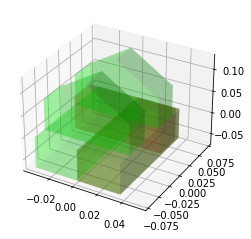

In [61]:
ax = visualize_mesh(goal_mesh, goal_mesh_pose, color=[0, 1, 0, 0.2])
ax = visualize_mesh(test_mesh, T2, ax=ax, color=[1, 0, 0, 0.2])
ax = visualize_mesh(test_mesh2, T22, ax=ax, color=[1, 0, 0, 0.2])
plt.show()

# Grasp Pose Discretization